<img src="attachment:ATLASOD.gif">

# Rediscovering the Higgs boson
This notebook uses ATLAS Open Data http://opendata.atlas.cern

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. 
This analysis loosely follows the [paper for the discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0040) (mostly Section 5 and 5.1).

For the sort of level of understanding required to follow this notebook, you can read this [article on the Higgs boson](http://hyperphysics.phy-astr.gsu.edu/hbase/Forces/higgs.html?fbclid=IwAR1ocxfiTOUW2dsdn1AMUL8IBnyBARS8mKKpWIlosTor66yRBdyyHH12naA#c1).

The datasets used in this notebook have already been filtered to include at least 2 photons per event, so that processing is quicker.

<img src="attachment:Hyy_feynman.png" width=40%>

## Contents: 

[Setting up](#setting_up) <br />
[Input data](#fraction) <br />
[Invariant mass calculation](#invariant_mass) <br />
[Plotting definitions](#plotting) <br />
[Data histogramming and plotting](#histogramming) <br />
[Applying cuts](#applying_cuts) <br />
[Fitting](#fitting) <br />
[Chi squared](#chi) <br />
[Residual Plot](#residual_plot) <br />
[Background chi sq](#backchi) <br />
[Fit chi sq](#fitchi) <br />
[$\Delta \chi^2$](#delchi) <br />
[Reduced Chi Squared](#redchi) <br />


## Setting up <a id="setting_up"></a>

(To be done every time you re-open this notebook)

We're going to be using a number of tools to help us:
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
* scipy: tool for statistical fitting

In [112]:
import pandas as pd # to store data as dataframe
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from scipy.optimize import curve_fit # for the signal and background fit

## Input data <a id="fraction"></a>

Samples to process, fraction of data used, and sample cycling function.

In [113]:
samples_list = ['data_B'] # add 'data_B','data_C','data_D' later if you want

fraction = 0.8 # increase this later if you want

DataFrames = {} # define empty dictionary to hold dataframes
for s in samples_list: # loop over samples
    DataFrames[s] = pd.read_csv('C:/Raj/sem7/PHY5132/Higgs/'+s+'.csv', index_col='entry') # read .csv file
all_data = pd.concat(DataFrames) # merge DataFrames into one
all_data

photon_pt_1  photon_pt_2  photon_eta_1  photon_eta_2  \
       entry                                                           
data_B 0          36.042613    34.589797      0.646185      2.348966   
       1          85.433719    71.684430      1.947769      1.516843   
       2          55.551480    40.063785     -0.834405     -1.710161   
       3          88.083883    60.003027      2.149978     -0.760504   
       4          72.062328    30.002311      2.151579      0.780485   
...                     ...          ...           ...           ...   
       1528712    56.400086    34.377891      1.380006      0.755261   
       1528713    38.537125    25.500365     -0.034016      0.818770   
       1528714   108.175891   101.582609      0.470512      1.333412   
       1528715    38.556348    35.617465     -0.182212      0.765375   
       1528716   135.089391    44.713047      1.097092      2.137238   

                photon_phi_1  photon_phi_2  photon_E_1  photon_E_2  \
       entry                                                         
data_B 0           -1.699354      1.485115   43.833000  182.810531   
       1           -2.190302      0.864054  305.665375  171.226016   
       2           -0.970063      2.492924   76.038188  114.395883   
       3           -2.806859      0.030374  383.215969   78.207508   
       4           -0.309630      3.035591  314.001813   39.613754   
...                      ...           ...         ...         ...   
       1528712      1.691946      1.584183  119.187539   44.657832   
       1528713     -1.596739      1.575010   38.559422   34.536187   
       1528714      1.827354     -1.394855  120.372523  206.087922   
       1528715     -0.675198      2.036463   39.198180   46.569113   
       1528716     -2.907868      0.034829  224.875328  192.131406   

                photon_isTightID_1  photon_isTightID_2  photon_etcone20_1  \
       entry                                                                
data_B 0                     False               False           4.352242   
       1                      True               False          -0.603572   
       2                     False               False          13.153976   
       3                      True               False           2.391702   
       4                     False                True          10.835105   
...                            ...                 ...                ...   
       1528712               False                True           2.220344   
       1528713                True               False           1.750884   
       1528714               False               False           5.256624   
       1528715               False               False          11.061548   
       1528716                True                True           1.507564   

                photon_etcone20_2  
       entry                       
data_B 0                 3.930282  
       1                 3.293683  
       2                 7.462173  
       3                 1.704068  
       4                10.820651  
...                           ...  
       1528712           0.632897  
       1528713           2.833171  
       1528714           7.000650  
       1528715           4.864035  
       1528716           0.778382  

[1528717 rows x 12 columns]

## Invariant mass calculation <a id="invariant_mass"></a>

1. If the energy of the 2 photons are *photon_E_1* and *photon_E_2*, write the sum of energy (*sumE*).
2. Write the x-momentum of photon_2 (*px_2*) using the definition of x-momentum of photon_1 momentum (*px_1*) written for you.
3. Do the same for y and z momenta of photon_2 (*py_2* and *pz_2*).
4. Write the sum of x-momentum (*sumpx*).
5. Do the same for y and z momenta (*sumpy* and *sumpz*)
6. Now you have the x, y, z components sumpx, sumpy, sumpz. The vector **sump** = (sumpx, sumpy, sumpz). Write the magnitude of total momentum, *sump*.

(**Tip!!** Momentum is a vector quantity, so use your mathematical vector knowledge to find its magnitude.)

The invariant mass *M* of a parent particle decaying to two daughter particles is related to properties of the daughter particles by the formula:

$$M^2=E^2-p^2,$$

where *E* is the total energy of the daughter particles, and *p* is the magnitude of the vector sum of the momenta of the daughter particles.

7. Write myy using the formula stated above for invariant mass

In [114]:
def calc_myy(photon_pt_1, photon_eta_1, photon_phi_1, photon_E_1,
             photon_pt_2, photon_eta_2, photon_phi_2, photon_E_2):
    # 1st photon is _1, 2nd photon is _2 etc

    # Step 1: Calculate the sum of energy (sumE)
    sumE = photon_E_1 + photon_E_2

    px_1 = photon_pt_1 * np.cos(photon_phi_1)  # x-momentum of photon_1
    # Step 2: Calculate the x-momentum of photon_2 (px_2)
    px_2 = photon_pt_2 * np.cos(photon_phi_2)

    py_1 = photon_pt_1 * np.sin(photon_phi_1)  # y-momentum of photon_1
    # Step 3: Calculate the y-momentum of photon_2 (py_2)
    py_2 = photon_pt_2 * np.sin(photon_phi_2)

    pz_1 = photon_pt_1 * np.sinh(photon_eta_1)  # z-momentum of photon_1
    # Step 4: Calculate the z-momentum of photon_2 (pz_2)
    pz_2 = photon_pt_2 * np.sinh(photon_eta_2)

    # Step 5: Calculate the sum of x-momenta (sumpx)
    sumpx = px_1 + px_2

    # Step 6: Calculate the sum of y-momenta (sumpy)
    sumpy = py_1 + py_2

    # Step 7: Calculate the sum of z-momenta (sumpz)
    sumpz = pz_1 + pz_2

    # Step 8: Calculate the magnitude of total momentum (sump)
    sump = np.sqrt(sumpx**2 + sumpy**2 + sumpz**2)

    # Step 9: Calculate the invariant mass using the formula M^2 = E^2 - p^2
    myy = np.sqrt(sumE**2 - sump**2)

    return myy

Then myy is calculated for each row in the data

In [115]:
# myy is calculated for each row in the data
all_data['myy'] = np.vectorize(calc_myy)(all_data['photon_pt_1'],
                                         all_data['photon_eta_1'],
                                         all_data['photon_phi_1'],
                                         all_data['photon_E_1'],
                                         all_data['photon_pt_2'],
                                         all_data['photon_eta_2'],
                                         all_data['photon_phi_2'],
                                         all_data['photon_E_2'])

## Plotting definitions <a id="plotting"></a>

1. Take a look at the [ATLAS Higgs discovery diphoton graph](https://ars.els-cdn.com/content/image/1-s2.0-S037026931200857X-gr004_lrg.jpg)
2. Write the x-axis minimum, *xmin*, from the [ATLAS Higgs discovery diphoton graph](https://ars.els-cdn.com/content/image/1-s2.0-S037026931200857X-gr004_lrg.jpg)
3. Write the x-axis maximum, *xmax*, from the [ATLAS Higgs discovery diphoton graph](https://ars.els-cdn.com/content/image/1-s2.0-S037026931200857X-gr004_lrg.jpg)
4. Write the x-axis separation between each data point, *step_size*, from the [ATLAS Higgs discovery diphoton graph](https://ars.els-cdn.com/content/image/1-s2.0-S037026931200857X-gr004_lrg.jpg)

In [116]:
# xmin = x-axis minimum in GeV from the Higgs discovery diphoton graph 
xmin = 100
# xmax = x-axis minimum in GeV from the Higgs discovery diphoton graph 
xmax = 160
# step_size = x-axis separation between data points in GeV from the Higgs discovery diphoton graph
step_size = 2 

bin_edges = np.arange(start=xmin, # The interval includes this value
                      stop=xmax+step_size, # The interval doesn't include this value
                      step=step_size ) # Spacing between values

bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

## Data histogramming and plotting <a id="histogramming"></a>
 
1. Read this section to be able to fill in the next missing pieces

Let's take a look at the data before plotting

The diphoton invariant mass can be accessed like:

In [117]:
print(all_data['myy'])

        entry  
data_B  0           97.783669
        1          160.017085
        2          102.436975
        3          327.781287
        4          115.330898
                      ...    
        1528712     28.358490
        1528713     68.476235
        1528714    229.317368
        1528715     81.063780
        1528716    176.263150
Name: myy, Length: 1528717, dtype: float64


Let's take a look at the array of bin edges

In [118]:
print(type(bin_edges)) # this tells you what type of variable bin_edges is
print(bin_edges) # this tells you the values of bin_edges

<class 'numpy.ndarray'>
[100 102 104 106 108 110 112 114 116 118 120 122 124 126 128 130 132 134
 136 138 140 142 144 146 148 150 152 154 156 158 160]


and the array of bin centres

In [119]:
print(type(bin_centres)) # this tells you what type of variable bin_centres is
print(bin_centres) # this tells you the values of bin_centres

<class 'numpy.ndarray'>
[101. 103. 105. 107. 109. 111. 113. 115. 117. 119. 121. 123. 125. 127.
 129. 131. 133. 135. 137. 139. 141. 143. 145. 147. 149. 151. 153. 155.
 157. 159.]


In [120]:
def plot_data():
    
    #####################
    # Filling a histogram
    # For you to complete
    # Complete the lines below
    histogrammed_data,_ = np.histogram( all_data['myy'],
                                       bins= bin_edges )
    # For you to complete
    #####################

    histogrammed_data_errors = np.sqrt( histogrammed_data ) # statistical error on the data

    #####################
    # Plot the data points
    # For you to complete
    # Complete the lines below then uncomment them
    plt.errorbar(x=bin_centres, 
                 y= histogrammed_data, 
                 yerr= histogrammed_data_errors,
                 label='data',
                 fmt='ko' ) # 'k' means black and 'o' means circles
    # For you to complete
    #####################
    
    return histogrammed_data

Call the function to plot the data: <a id="view_plot_before"></a>

array([27506, 26446, 25458, 24344, 23470, 22164, 21384, 20593, 19485,
       18832, 17831, 17484, 16536, 15731, 15221, 14399, 14023, 13231,
       12758, 12333, 11834, 11382, 11113, 10670, 10232,  9636,  9303,
        8892,  8635,  8172], dtype=int64)

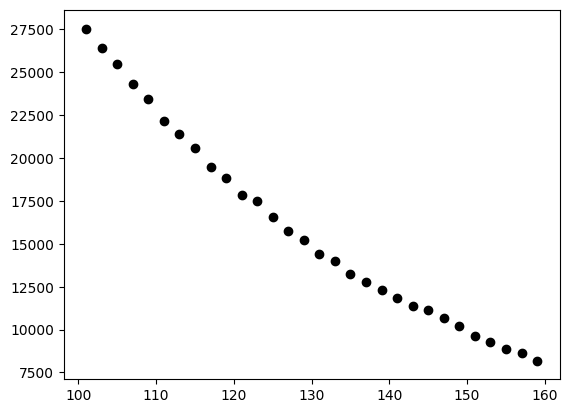

In [121]:
plot_data()

Making a histogram of the number of times a particular $\sqrt{E^2-p^2}$ result occurs is a way to search for heavy particles that decay so quickly that they can’t be measured by the ATLAS detector directly. In this analysis, we’re searching for the Higgs boson decaying to two photons.

Let's try separate the signal from the background to see a more significant bump around the Higgs mass.

## Applying cuts <a id="applying_cuts"></a>

In [122]:
def select_eta(photon_eta_1, photon_eta_2):
    # Want to keep events where absolute value of photon_eta is outside the range 1.37 to 1.52
    # If absolute value of either photon_eta is between 1.37 and 1.52, return False
    if 1.37 <= abs(photon_eta_1) <= 1.52 or 1.37 <= abs(photon_eta_2) <= 1.52:
        return False
    else:
        return True

all_data = all_data[np.vectorize(select_eta)(all_data.photon_eta_1, all_data.photon_eta_2)]

def select_pt(photon_pt_1, photon_pt_2):
    # Want to keep events where photon_pt_1 > 40 GeV and photon_pt_2 > 30 GeV
    if photon_pt_1 > 40 and photon_pt_2 > 30:
        return True
    else:
        return False

all_data = all_data[np.vectorize(select_pt)(all_data.photon_pt_1, all_data.photon_pt_2)]

def select_etcone20(photon_etcone20_1, photon_etcone20_2):
    # Want to keep events where isolation eT < 4 GeV for both photons
    if photon_etcone20_1 < 4 and photon_etcone20_2 < 4:
        return True
    else:
        return False

all_data = all_data[np.vectorize(select_etcone20)(all_data.photon_etcone20_1, all_data.photon_etcone20_2)]

def select_isTightID(photon_isTightID_1, photon_isTightID_2):
    # Want to keep events where both photons are well reconstructed (isTightID == True)
    if photon_isTightID_1 and photon_isTightID_2:
        return True
    else:
        return False

all_data = all_data[np.vectorize(select_isTightID)(all_data.photon_isTightID_1, all_data.photon_isTightID_2)]

After making the cuts, check out how the plot has changed. <a id="view_plot_after"></a>

array([1779, 1634, 1610, 1588, 1513, 1435, 1330, 1283, 1188, 1175, 1165,
       1139,  996, 1000,  866,  887,  846,  814,  767,  676,  690,  691,
        634,  607,  599,  509,  534,  481,  489,  478], dtype=int64)

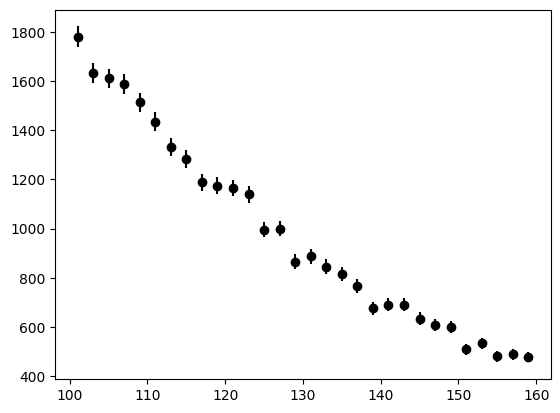

In [123]:
plot_data()

Now that we've applied cuts to separate signal from background, let's make a fit.

## Fitting <a id="fitting"></a>

Define function to fit to data:

gaussian centre = 122.0393432043123
gaussian sigma = 0.43516092172231396


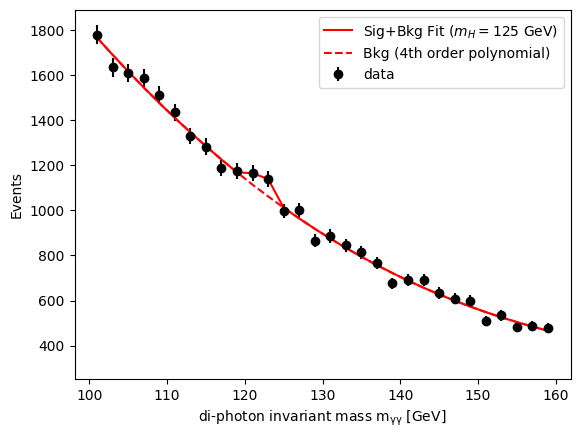

In [124]:
def func(x, a, b, c, d, e, A, mu, sigma): # define function for polynomial + Gaussian
    return a + b*x + c*x**2+ d*x**3 + e*x**4 + A*np.exp(-0.5*((x-mu)/sigma)**2)

data = plot_data() # draw a plot
errors = np.sqrt(data) # get the errors on the y values

# data fit
popt,_ = curve_fit(func, # function to fit
                   bin_centres, # x
                   data, # y
                   p0=[data.max(),0,0,0,0,91.7,125,2.4], # initial guesses for the fit parameters
                   sigma=errors) # errors on y

# background part of fit
a = popt[0] # a of a + b*x + c*x^2 + d*x^3 + e*x^4
b = popt[1] # b of a + b*x + c*x^2 + d*x^3 + e*x^4
c = popt[2] # c of a + b*x + c*x^2 + d*x^3 + e*x^4
d = popt[3] # d of a + b*x + c*x^2 + d*x^3 + e*x^4
e = popt[4] # e of a + b*x + c*x^2 + d*x^3 + e*x^4
# get the background only part of the fit to data
background_fit = a + b*bin_centres + c*bin_centres**2 + d*bin_centres**3 + e*bin_centres**4

A = popt[5] # amplitude of Gaussian
mu = popt[6] # centre of Gaussian
sigma = popt[7] # width of Gaussian
fit = func(bin_centres,a,b,c,d,e,A,mu,sigma) # call func with fitted parameters

# plot the signal + background fit
plt.plot(bin_centres, # x
         fit, # y
         '-r', # single red line
         label='Sig+Bkg Fit ($m_H=125$ GeV)' )

# plot the background only fit
plt.plot(bin_centres, # x
         background_fit, # y
         '--r', # dashed red line
         label='Bkg (4th order polynomial)' )

plt.ylabel( 'Events' ) # write y-axis label for main axes
plt.ylim( bottom=250 ) # set the y axis limit for the main axes
plt.xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]') # x-axis label

# draw the legend
plt.legend()

print('gaussian centre = '+str(mu))
print('gaussian sigma = '+str(sigma))

The steps that happen above are:
1. A histogram of $M$ vs. the number of events is drawn.
2. The error bars on the number of events are given by statistical uncertainty, i.e. the square root of the number of events, e.g. 10000 $\pm$ 100. The errors bars on $M$ are given by the width of the histogram bin. 
3. A 4th order polynomial + Gaussian fit is used around the peak in $M$. The parameters of the fit are estimated, using the bin centres as *x* values, measured data points as the *y* values and error bars as the *y* uncertainty.
4. To find the centre of the Gaussian, we need to subtract the polynomial background. 
5. The fit is performed to find the values of the fit parameters that minimize the $\chi^2$. 
6. The polynomial+Gaussian fit is plotted.
7. The polynomial only fit is plotted.
8. Gaussian centre and Gaussian sigma are printed.

Let's print the array of fitted values to give you an idea of how it looks.

In [125]:
print(background_fit)

[1765.84316676 1689.83342241 1616.26143113 1545.11939648 1476.39712007
 1410.08200158 1346.15903879 1284.61082752 1225.41756168 1168.55703321
 1114.00463218 1061.73334668 1011.7137629   963.91406507  918.30003553
  874.83505465  833.48010089  794.19375078  756.93217892  721.64915797
  688.29605867  656.82184982  627.1730983   599.29396905  573.1262251
  548.60922752  525.67993547  504.27290617  484.32029492  465.75185508]


In [126]:
print(fit)

[1765.84316676 1689.83342241 1616.26143113 1545.11939648 1476.39712007
 1410.08200158 1346.15903879 1284.61082752 1225.41756168 1168.55703324
 1164.99999998 1139.00000006 1011.71376298  963.91406507  918.30003553
  874.83505465  833.48010089  794.19375078  756.93217892  721.64915797
  688.29605867  656.82184982  627.1730983   599.29396905  573.1262251
  548.60922752  525.67993547  504.27290617  484.32029492  465.75185508]


and now the array of data values

In [127]:
print(data)

[1779 1634 1610 1588 1513 1435 1330 1283 1188 1175 1165 1139  996 1000
  866  887  846  814  767  676  690  691  634  607  599  509  534  481
  489  478]


and lastly the array of data errors

In [128]:
print(errors)

[42.17819342 40.42276586 40.1248053  39.84971769 38.89730068 37.88139385
 36.46916506 35.81898938 34.46737588 34.278273   34.13209633 33.74907406
 31.55946768 31.6227766  29.42787794 29.78254522 29.08607914 28.53068524
 27.69476485 26.         26.26785107 26.28687886 25.17935662 24.63736999
 24.4744765  22.56102835 23.10844002 21.9317122  22.11334439 21.86321111]


## Chi squared <a id="chi"></a>

Recall that the function for $\chi^2$ is 
$$\Sigma{(\frac{fit-data}{errors})^2}$$ 
where the sum is over each data point



In [129]:
# calculate chi squared
fit_minus_data = fit-data
fit_minus_data_over_errors = fit_minus_data/errors
fit_minus_data_over_errors_squared = (fit_minus_data/errors)**2
chisq = np.sum(fit_minus_data_over_errors_squared)

print(fit_minus_data_over_errors_squared)
print('χ² = '+str(chisq))
print('χ²/ndf = ', chisq/22)

[9.73031258e-02 1.90781583e+00 2.43512546e-02 1.15790060e+00
 8.85506160e-01 4.32687558e-01 1.96326718e-01 2.02242035e-03
 1.17851340e+00 3.53292091e-02 4.78511261e-19 3.14576585e-18
 2.47914003e-01 1.30219470e+00 3.15853778e+00 1.66838665e-01
 1.85281175e-01 4.81925686e-01 1.32152570e-01 3.08261187e+00
 4.20784938e-03 1.69051512e+00 7.35119666e-02 9.78301696e-02
 1.11761641e+00 3.08230040e+00 1.29631973e-01 1.12604607e+00
 4.47845392e-02 3.13843209e-01]
χ² = 22.355500433276678
χ²/ndf =  1.0161591106034853


## Residual plot <a id="residual_plot"></a>


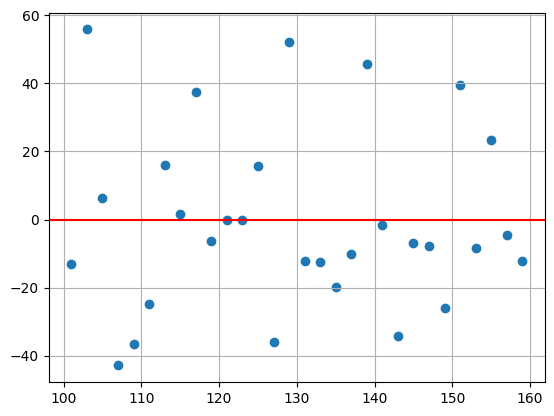

In [130]:
plt.scatter(bin_centres, fit_minus_data)
plt.axhline(y=0, c = 'r')
plt.grid(True)

## Background chi sq <a id="backchi"></a>


In [136]:
import numpy as np
 
observed_data = data #??
errors = np.sqrt(data)
chi_squared_stats1 = []

for i in range(1000):
    model = []
    for j in range (len(background_fit)):
        each_bin = np.random.poisson(background_fit[j], 2000)
        model.append(np.mean(each_bin))
    #print("bg mosel =", model)
    chi_squared_stats1.append(np.sum((((model - observed_data) / errors) ** 2)))

# print(chi_squared_stats1)

[29.946298287876008, 29.651177333054232, 29.22139028711238, 29.742088534701583, 30.107468469864006, 29.85141482800565, 29.86645063526952, 29.808541472536465, 29.516767167594818, 29.840253866124957, 29.580432337615594, 30.21591102069434, 30.040227217114193, 29.977431608743856, 29.835369747565004, 29.63444620465541, 30.059553320910062, 30.166594918343883, 29.96031893724471, 30.24251879029136, 30.106339951400003, 29.96448283888966, 29.61003515801096, 29.84277064925403, 29.873868591057548, 30.082183409320958, 29.411009293950528, 29.94817369446059, 29.768802991295967, 29.77497230949995, 29.808020394379295, 30.085780513468418, 29.852026071368716, 29.81855121831626, 29.806531548081747, 29.954813531168273, 29.63962860664309, 30.205795304045974, 30.208634575245707, 29.866476625047795, 29.830889259954184, 30.131282284288954, 29.691163978658874, 29.782219505302447, 29.494772120808822, 29.916368500930627, 29.77266581307653, 29.44741850220006, 29.820820475267197, 29.6991496454697, 29.94296380120933

## Fit chi sq <a id="fitchi"></a>


In [135]:
import numpy as np
 
observed_data = data
errors = np.sqrt(data)
chi_squared_stats2 = []


for i in range(1000):
    model = []
    for j in range (len(fit)):
        each_bin = np.random.poisson(fit[j], 1000)
        model.append(np.mean(each_bin))
    chi_squared_stats2.append(np.sum((((model - observed_data) / errors) ** 2)))

# print(chi_squared_stats2)

[22.471942634627535, 21.98237959632841, 22.289231293853028, 22.694546283521586, 22.384410114521163, 22.010015282558935, 22.406525140627604, 22.207068535766204, 22.281735915778018, 22.705090682723327, 22.42552682965153, 21.909976425933287, 22.594694788576323, 22.75230153368516, 21.98584257675159, 22.718886328709324, 22.239999687865065, 22.70183200571283, 22.117935363225616, 21.837169561562106, 22.335990776325314, 22.217183976848382, 22.236510368651015, 22.255926015344098, 23.08899366879615, 22.600483028681587, 22.27238651353251, 22.094641320908565, 22.423827915910415, 22.35873970673298, 22.31897205107583, 22.100864956683314, 22.10539319898916, 22.8899484698641, 22.62071853995933, 22.307818361763168, 22.799791409702138, 22.17711124714263, 22.115018801667023, 22.665783570664193, 22.376269593905725, 22.575668941541743, 22.206331945364617, 21.99036001770358, 22.072898263968984, 21.95207251267649, 22.497673442764537, 22.534464021593287, 22.232256421432712, 22.863493881974556, 22.567501600349

## $\Delta \chi^2$ <a id="delchi"></a>


29.829271923151314 22.355500433276678 7.473771489874636


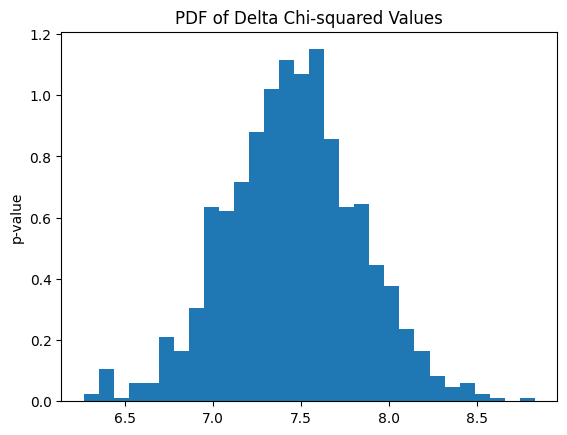

In [133]:
delchisq = [-np.array(chi_squared_stats2) + np.array(chi_squared_stats1)]

import numpy as np
import matplotlib.pyplot as plt
plt.hist(delchisq, bins=30, density=True)
plt.ylabel("p-value")
bgchi = np.sum(((background_fit - data)/errors)**2)
obsdel = -(chisq - bgchi)
print(bgchi, chisq, obsdel)

plt.title("PDF of Delta Chi-squared Values")
plt.show()


## Reduced Chi Squared <a id="redchi"></a>

### χ² = 22.355500433276678

### reduced χ² = χ²/ndf = 1.0161591106034853